In [345]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

df = pd.read_csv('telco_processed.csv')
print("Dataset shape:", df.shape)

Dataset shape: (7021, 30)


In [346]:
print("Data types:")
print(df.dtypes)

Data types:
gender                                       int64
SeniorCitizen                                int64
Partner                                      int64
Dependents                                   int64
tenure                                       int64
PhoneService                                 int64
MultipleLines                                int64
OnlineSecurity                               int64
OnlineBackup                                 int64
DeviceProtection                             int64
TechSupport                                  int64
StreamingTV                                  int64
StreamingMovies                              int64
PaperlessBilling                             int64
MonthlyCharges                             float64
TotalCharges                               float64
Churn                                        int64
TotalServices                                int64
HasInternet                                  int64
TenureGroup        

In [347]:
print("\nNon-numeric columns:")
non_numeric_cols = df.select_dtypes(include=['object']).columns
print(non_numeric_cols)


Non-numeric columns:
Index(['TenureGroup'], dtype='object')


In [348]:
if len(non_numeric_cols) > 0:
    print("\nUnique values in non-numeric columns:")
    for col in non_numeric_cols:
        print(f"{col}: {df[col].unique()}")


Unique values in non-numeric columns:
TenureGroup: ['0-1yr' '2-4yr' '1-2yr' '4-6yr' nan]


In [349]:
df = pd.get_dummies(df, columns=non_numeric_cols, drop_first=True)
print("\nAfter processing - Data types:")
print(df.dtypes)
print("New shape:", df.shape)


After processing - Data types:
gender                                       int64
SeniorCitizen                                int64
Partner                                      int64
Dependents                                   int64
tenure                                       int64
PhoneService                                 int64
MultipleLines                                int64
OnlineSecurity                               int64
OnlineBackup                                 int64
DeviceProtection                             int64
TechSupport                                  int64
StreamingTV                                  int64
StreamingMovies                              int64
PaperlessBilling                             int64
MonthlyCharges                             float64
TotalCharges                               float64
Churn                                        int64
TotalServices                                int64
HasInternet                                  int64

In [350]:
X = df.drop('Churn', axis=1)
y = df['Churn']

print("Features shape:", X.shape)
print("Target distribution:")
print(y.value_counts())

Features shape: (7021, 31)
Target distribution:
Churn
0    5164
1    1857
Name: count, dtype: int64


In [351]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Training set:", X_train.shape)
print("Testing set:", X_test.shape)

Training set: (5616, 31)
Testing set: (1405, 31)


In [352]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Data scaling completed")
print("Training data - Mean:", X_train_scaled.mean(), "Std:", X_train_scaled.std())
print("Test data - Mean:", X_test_scaled.mean(), "Std:", X_test_scaled.std())

Data scaling completed
Training data - Mean: -1.7345640491340557e-18 Std: 1.0
Test data - Mean: -0.0023373149177561966 Std: 1.0022027776621183


In [353]:
model = keras.Sequential([
    layers.Input(shape=(X_train_scaled.shape[1],)),
    layers.Dense(128, activation='relu'),  # Slightly larger first layer
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("Neural Network architecture:")
model.summary()

Neural Network architecture:


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_53 (Dense)                │ (None, 128)            │         4,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,465 (56.50 KB)

 Trainable params: 14,465 (56.50 KB)

 Non-trainable params: 0 (0.00 B)

In [354]:
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=15,
        restore_best_weights=True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=10,
        min_lr=1e-7
    )
]

In [355]:
history = model.fit(
    X_train_scaled, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    verbose=1,
    callbacks=callbacks
)

Epoch 1/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7718 - loss: 0.4688 - val_accuracy: 0.7802 - val_loss: 0.4335 - learning_rate: 0.0010
Epoch 2/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7945 - loss: 0.4341 - val_accuracy: 0.7918 - val_loss: 0.4412 - learning_rate: 0.0010
Epoch 3/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7950 - loss: 0.4213 - val_accuracy: 0.7963 - val_loss: 0.4367 - learning_rate: 0.0010
Epoch 4/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7988 - loss: 0.4192 - val_accuracy: 0.7980 - val_loss: 0.4314 - learning_rate: 0.0010
Epoch 5/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8023 - loss: 0.4210 - val_accuracy: 0.7954 - val_loss: 0.4301 - learning_rate: 0.0010
Epoch 6/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8032 - loss: 0.4145 - val_accuracy: 0.7963 - val_loss: 0.4392 - learning_rate: 0.0010
Epoch 7/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8132 - loss: 0.

In [356]:
train_loss, train_accuracy = model.evaluate(X_train_scaled, y_train, verbose=0)
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test, verbose=0)

print("=== BASIC NEURAL NETWORK PERFORMANCE ===")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")


=== BASIC NEURAL NETWORK PERFORMANCE ===
Training Accuracy: 0.8203
Testing Accuracy: 0.7943


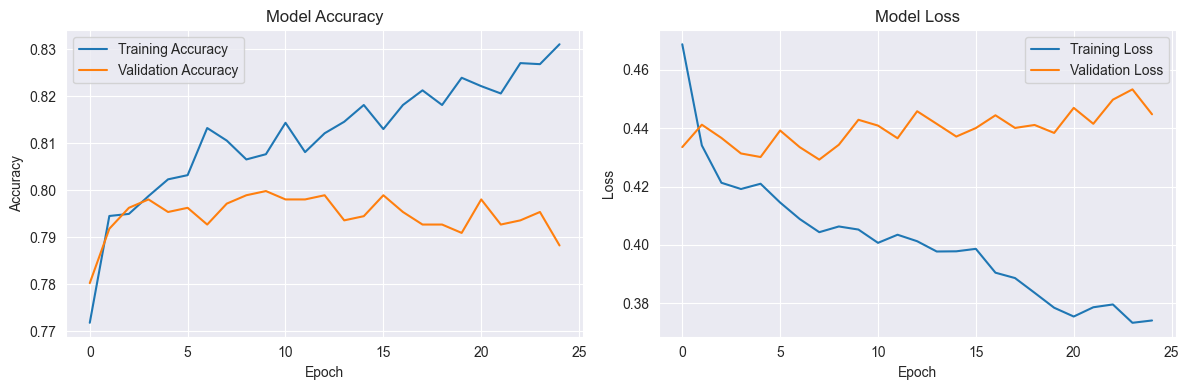

In [357]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [358]:
nn_basic_results = {
    'model': 'NeuralNetwork_Basic',
    'train_accuracy': train_accuracy,
    'test_accuracy': test_accuracy,
    'architecture': '64-32-1 with Dropout'
}

print("Basic Neural Network results saved")

Basic Neural Network results saved
